In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d drscarlat/melanoma

Dataset URL: https://www.kaggle.com/datasets/drscarlat/melanoma
License(s): unknown
100% 5.26G/5.26G [01:01<00:00, 118MB/s] 
100% 5.26G/5.26G [01:01<00:00, 91.3MB/s]


In [ ]:
# prompt: code for unziping file
import zipfile
zip_ref=zipfile.ZipFile('/content/melanoma.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Directories for the dataset
train_dir = '/content/DermMel/train_sep'
test_dir = '/content/DermMel/test'

# Parameters
img_size = (224, 224)  # Image size to resize (224x224 for DenseNet)
batch_size = 32
epochs = 20
learning_rate = 0.0001
num_classes = 2  # Adjust based on the number of classes (2 for benign/malignant)


In [ ]:
import os
import shutil

# Function to remove .ipynb_checkpoints folder from a directory
def remove_checkpoints(directory):
    for root, dirs, files in os.walk(directory):
        if '.ipynb_checkpoints' in dirs:
            # Remove the folder
            shutil.rmtree(os.path.join(root, '.ipynb_checkpoints'))
            print(f"Removed: {os.path.join(root, '.ipynb_checkpoints')}")

# Paths to your train and test directories
train_dir = '/content/DermMel/train_sep'
test_dir = '/content/DermMel/test'

# Remove .ipynb_checkpoints from both directories
remove_checkpoints(train_dir)
remove_checkpoints(test_dir)

Removed: /content/DermMel/train_sep/.ipynb_checkpoints
Removed: /content/DermMel/test/.ipynb_checkpoints


In [ ]:
# Data augmentation and preprocessing for training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize images
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Preprocessing for validation/testing (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'  # Use 'categorical' for multi-class classification
)

# Load testing data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)




Found 10682 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


In [ ]:
# Load the pre-trained DenseNet121 model without the top classification layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers to prevent training them initially
base_model.trainable = False

# Add custom layers on top of DenseNet
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global pooling layer
x = Dense(128, activation='relu')(x)  # Fully connected layer
predictions = Dense(1, activation='sigmoid')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,

)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


334/334 ━━━━━━━━━━━━━━━━━━━━ 274s 716ms/step - accuracy: 0.7673 - loss: 0.4951 - val_accuracy: 0.9219 - val_loss: 0.2687
Epoch 2/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 193s 560ms/step - accuracy: 0.9141 - loss: 0.2488 - val_accuracy: 0.9275 - val_loss: 0.2594
Epoch 3/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 189s 556ms/step - accuracy: 0.9186 - loss: 0.2146 - val_accuracy: 0.9304 - val_loss: 0.2126
Epoch 4/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 187s 547ms/step - accuracy: 0.9296 - loss: 0.1969 - val_accuracy: 0.9318 - val_loss: 0.2223
Epoch 5/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 200s 546ms/step - accuracy: 0.9331 - loss: 0.1819 - val_accuracy: 0.9318 - val_loss: 0.2172
Epoch 6/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 202s 542ms/step - accuracy: 0.9293 - loss: 0.1903 - val_accuracy: 0.9326 - val_loss: 0.2143
Epoch 7/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 186s 545ms/step - accuracy: 0.9200 - loss: 0.1989 - val_accuracy: 0.9318 - val_loss: 0.2199
Epoch 8/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 186s 548ms/step - accuracy: 0.9355 - loss: 0.18

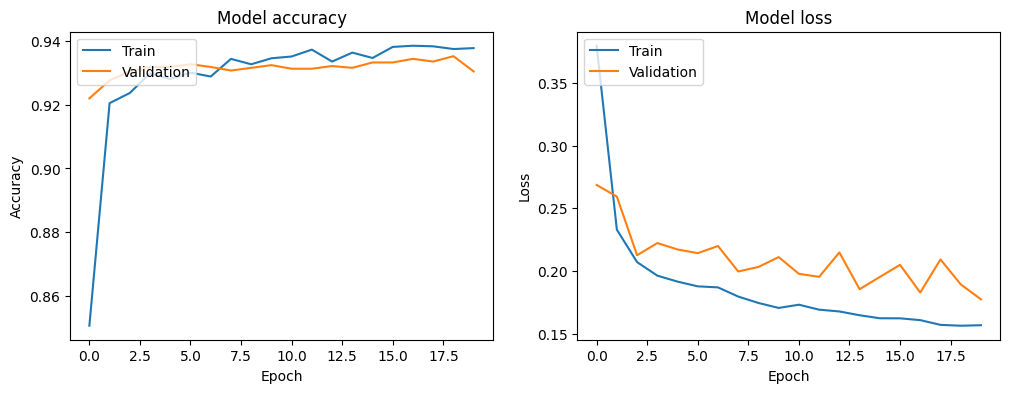

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

112/112 ━━━━━━━━━━━━━━━━━━━━ 26s 232ms/step - accuracy: 0.9323 - loss: 0.1769
Test Loss: 0.17739443480968475
Test Accuracy: 0.9303566217422485


In [ ]:
model.save('DenseNet-121.h5')

In [ ]:

import mlxtend